In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime as dt
sns.set(rc={'axes.facecolor':'lightgray', 'figure.facecolor':'white'})
plt.rcParams['font.family'] = 'Times New Roman'

# Spatially plotting results
Comparing Twitter and MPD on a spatial level.

### Load data

In [2]:
# barrios
path = r"data\shps\neighborhoods.shp"
barrios = gpd.read_file(path).set_index('CODBAIRRO')
barrios = barrios.sort_index()

In [3]:
# Load Twitter Stats
statistics_twitter = {}
wanted_stats = ['number_unique_users', 'no_real_movements', 'jl_simple_means_over_user_means',\
                  'graph_modularity', 'rel_tweets_in_residential_areas', 'mean_rog']

# Load only subsets
for file in [file for file in os.listdir("data/") if 'days' in file]:
    if 'statistics' in file:
        data = pd.read_csv("data/"+file)
        if str(data['start_date'][0])[-2:] == ".0":
            data['start_date'] = data['start_date'].apply(lambda x: dt.strptime(str(x), "%Y%m%d.0"))
        else:
            data['start_date'] = data['start_date'].apply(lambda x: dt.strptime(str(x), "%Y%m%d"))
        data['middle_date'] = data['middle_date'].apply(lambda x: dt.strptime(str(x), "%Y%m%d"))
        data = data.set_index('middle_date')
        data = data.drop(columns=["Unnamed: 1"])
        #data = data[wanted_stats]
        statistics_twitter[file.split("_")[1].split(".")[0]] = data
        

In [4]:
# Load MPD data from Steffen
data_path = "data/statistics/mobility_metrics_paper.csv"
mpd = pd.read_csv(data_path, sep=';', decimal=',')
mpd['date'] = mpd.date.apply(lambda x: dt.strptime(str(x), "%Y-%m-%d 00:00:00"))
mpd = mpd.set_index('date')
mpd.columns = ['number_unique_users', 'weekly citywide penetration rate', 'no_real_movements', 'jl_simple_means_over_user_means',\
                  'graph_modularity', 'rel_tweets_in_residential_areas', 'mean_rog']

# USED IN PAPER: Correlation of single OD Matrix
First, load in normalized od-matrices from notebook C_01, then plot them in a scatterplot with a logarithmic scale.

In [5]:
od_twitter_total_norm = np.load("data/post_processing/total_twitter_od_normalized.npy")
od_mpd_total_norm = np.load("data/post_processing/total_mpd_od_normalized.npy")

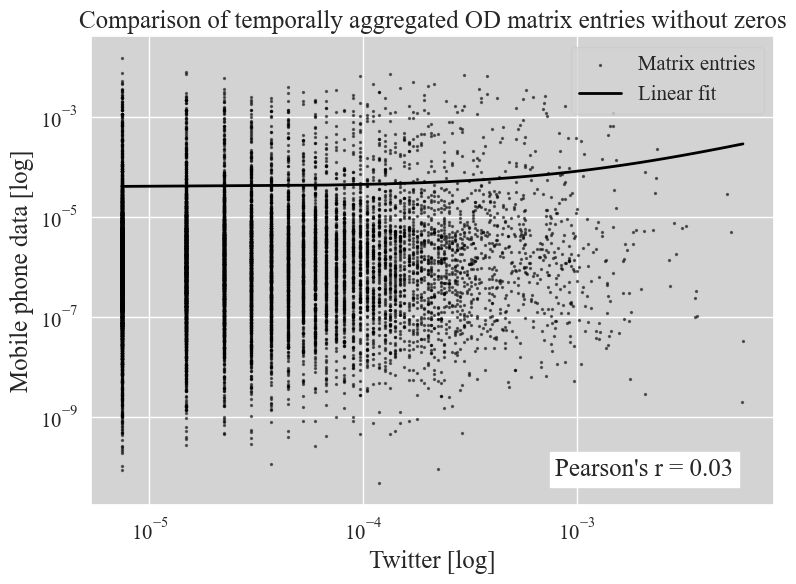

In [6]:
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.set_title("Comparison of temporally aggregated OD matrix entries without zeros", size=18)
x = od_twitter_total_norm.flatten()
y = od_mpd_total_norm.flatten()

##### FILTER ZEROS #####
x_new = []
y_new = []
for i in range(len(x)):
    if x[i] != 0 and y[i] != 0:
        x_new.append(x[i])
        y_new.append(y[i])  
x = x_new
y = y_new
##### FILTER ZEROS #####

plt.scatter(x, y, s=2, alpha=0.5, color='black')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

x_range = np.linspace(min(x), max(x), 100)
plt.plot(x_range, p(x_range), "black", linewidth=2)

ax.set_xlabel('Twitter [log]', size=18)
ax.set_ylabel('Mobile phone data [log]', size=18)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(['Matrix entries', 'Linear fit'], fontsize="15", loc='upper right')
ax.tick_params(axis='both', which='major', labelsize=15)

_ = ax.text(0.68, 0.1, fr"Pearson's r = {round(np.corrcoef(x, y)[0,1], 2)}", horizontalalignment='left', \
        verticalalignment='top', transform=ax.transAxes, size=18, backgroundcolor='white')

plt.tight_layout()
plt.show()

# "figure11"

C:\Users\arbeit\anaconda3\envs\arbeit4\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\arbeit\anaconda3\envs\arbeit4\Lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\arbeit\anaconda3\envs\arbeit4\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\arbeit\anaconda3\envs\arbeit4\Lib\site-packages\geopandas\plotting.py:48: Shapely

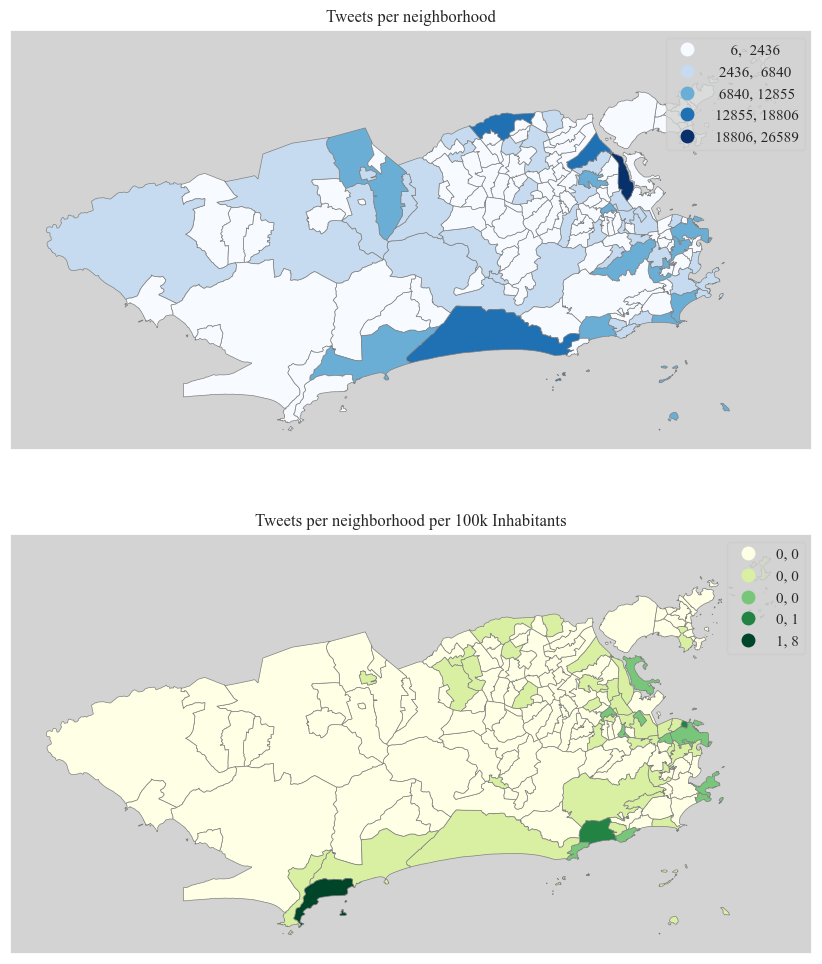

In [7]:
fig, axs = plt.subplots(2, figsize=(12, 12))
barrios.plot(column='counts', ax=axs[0], cmap='Blues', legend=True, scheme="NaturalBreaks", \
             legend_kwds={"fmt": "{:.0f}"}, linewidth=0.5, edgecolor='grey')
axs[0].set_title('Tweets per neighborhood')


barrios.plot(column='counts_per', ax=axs[1], cmap='YlGn', legend=True, scheme="NaturalBreaks", \
             legend_kwds={"fmt": "{:.0f}"}, linewidth=0.5, edgecolor='grey')
axs[1].set_title('Tweets per neighborhood per 100k Inhabitants')


for ax in axs:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# USED IN PAPER: Inhabitants and Tweets
A scatterplot, with number of tweets on Y and population on the X axis.

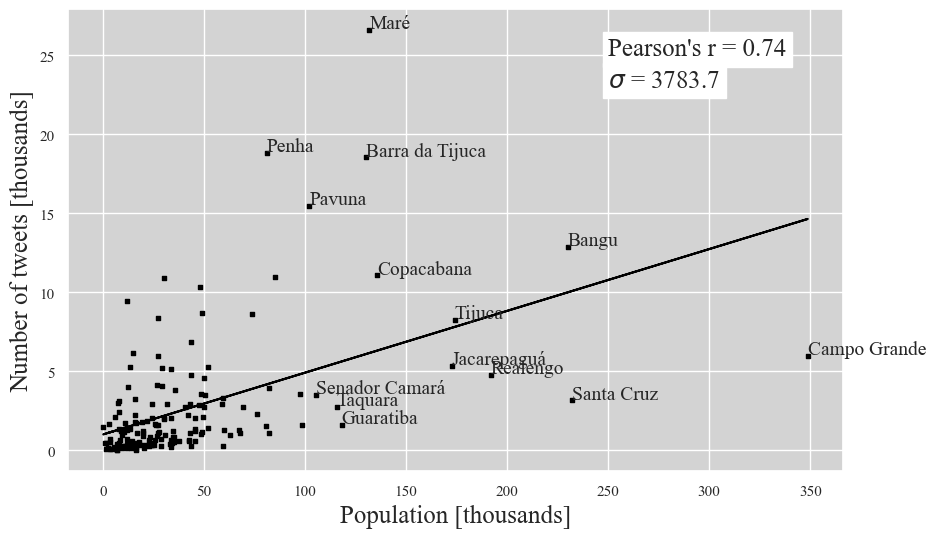

In [8]:
fig , ax= plt.subplots(1, figsize=(10,6))
#fig.suptitle("Ratio of tweets per neighborhood population", size=18, y=0.92)

y = barrios['counts']/1000
x = barrios['popsize']/1000
ax.scatter(x, y, marker='s', c='black', s=10)
ax.set_ylabel("Number of tweets [thousands]", size=18)
ax.set_xlabel("Population [thousands]", size=18)
for i in barrios.index:
    if y[i] > 15 or x[i] > 100:
        plt.text(x=x[i], y=y[i]+0.1, s=barrios.NOME[i], size=14)
        
# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

plt.text(250, 25, fr"Pearson's r = {round(np.corrcoef(x, y).mean(), 2)}", size=18, backgroundcolor='white')
plt.text(250, 23, fr'$\sigma$ = {round((y*1000).std(), 2)}', size=18, backgroundcolor='white')

barrios['counts'].std()

plt.plot(x,p(x), "black")

# figure3